In [2]:
import pandas as pd
import json

cleaned_csv_path = r'../Database/processed/form_1_cleaned.csv'

code_dict_path = r'../Database/processed/code_dict.json'

df = pd.read_csv(cleaned_csv_path)

with open(code_dict_path, 'r') as file:
    code_dict = json.load(file)



C:\Users\benol\AppData\Local\Temp\ipykernel_12264\2492411773.py:8: DtypeWarning: Columns (370,371,372) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(cleaned_csv_path)


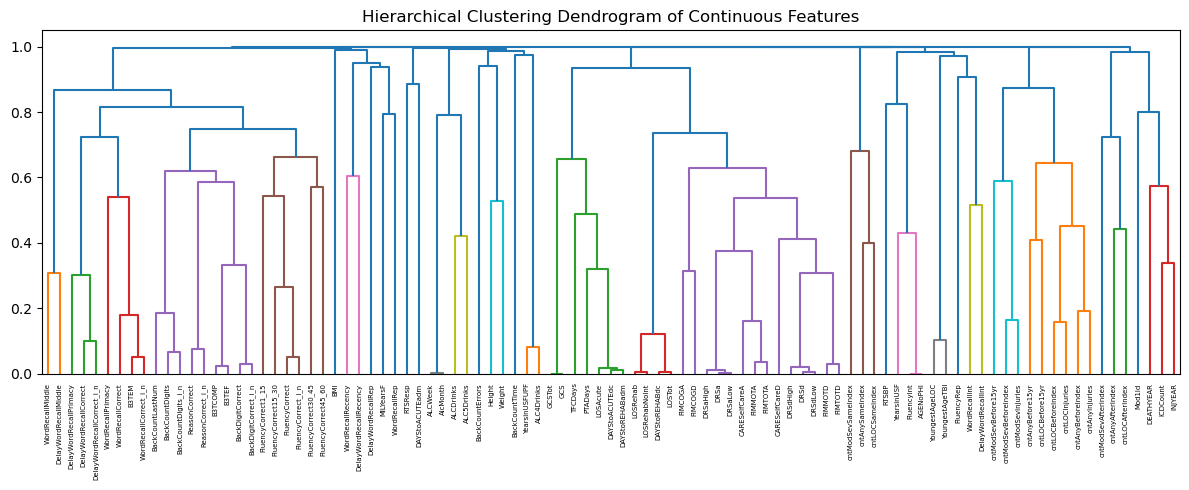

In [3]:

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

cont_cols = code_dict["numeric_cols"]

df_cont = df[cont_cols]
df_cont = df_cont.loc[:, df_cont.std() != 0]


#compute absolute correlation and dissimilarity
correlation_matrix = df_cont.corr()
dissimilarity = 1 - abs(correlation_matrix)
dissimilarity.fillna(1.0, inplace=True)  # Treat uncorrelated pairs as maximally dissimilar


#condense the dissimilarity matrix
dissimilarity_condensed = squareform(dissimilarity.values, checks=False)

#perform linkage and plot dendrogram
Z = linkage(dissimilarity_condensed, 'complete')

plt.figure(figsize=(12, 5))
dendrogram(Z, labels=df_cont.columns, orientation='top', leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram of Continuous Features")
plt.tight_layout()
plt.show()

[21  8  8 12  6 15 15 10  7  7  7 10  3  1  1  2  1  3 17  1  1  1  1  1
  1 18 15  1  1  9  1 11  1  1  2  1  4 17  7 15  1  1  1  1  1  5 13 13
 20 19 19 19 14 20 19 19 19 14 20 19 19 19 14  6 12 12 13 21  1 13 13 13
 13 13 13 13 13 13 13 13 13  1 12 21 21 12 13 13 13 12  1 12  1 16 16]


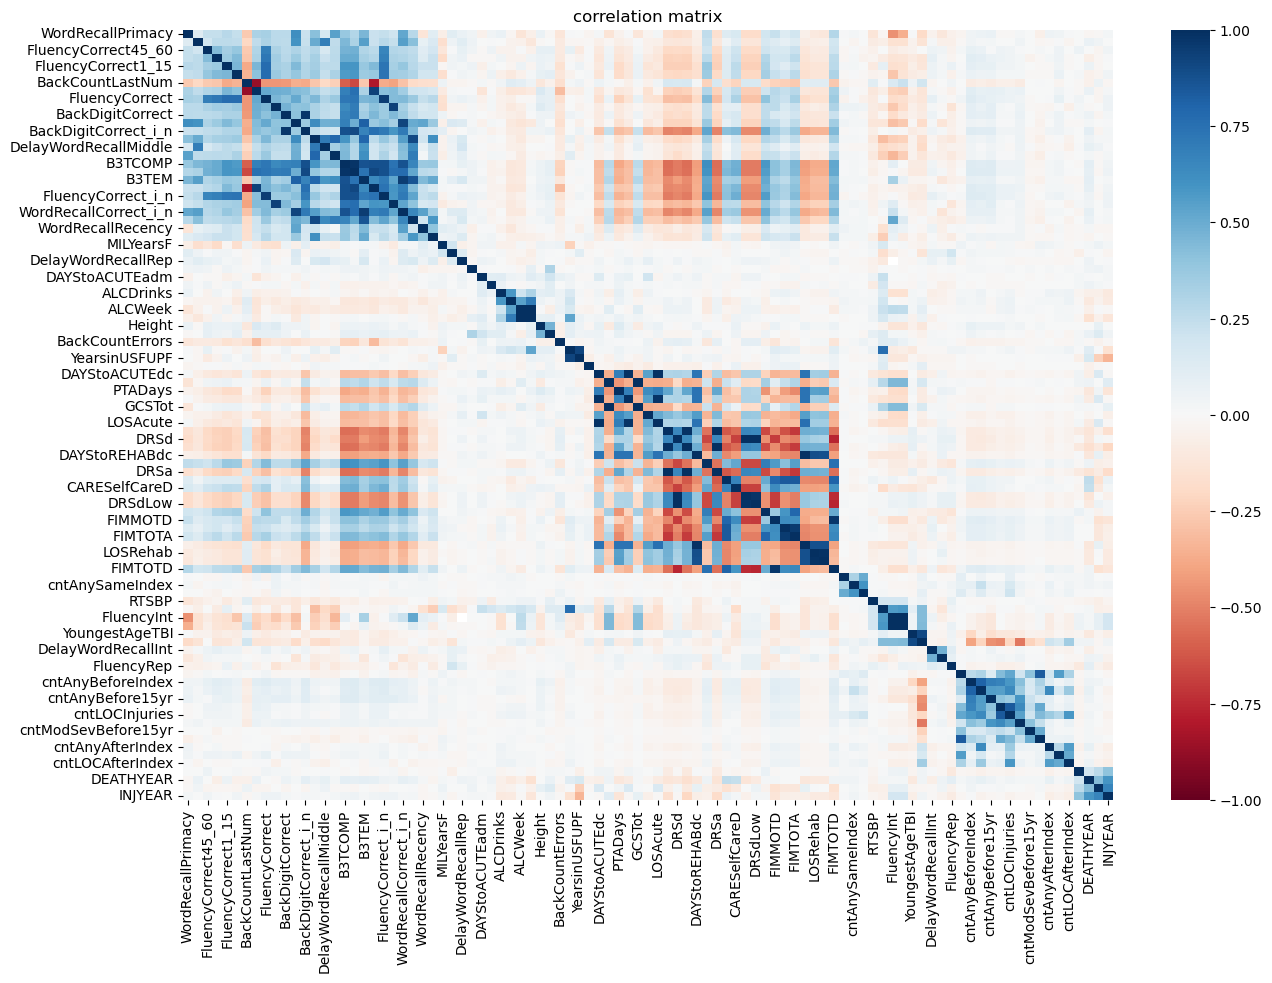

In [4]:
import numpy as np
import seaborn as sns


#get cluster labels
threshold = 0.9
labels = fcluster(Z, threshold, criterion="distance")
print(labels)

#sort labels
labels_order = np.argsort(labels)

#rebuild dataframe in labels order
for idx, i in enumerate(df_cont.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df_cont[i])
    else:
        df_to_append = pd.DataFrame(df_cont[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

#create correlation matrix
clustered_corr = clustered.corr()

#plot
plt.figure(figsize=(15,10))
sns.heatmap(round(clustered_corr,2),cmap='RdBu', annot=False, 
            annot_kws={"size": 7}, vmin=-1, vmax=1)
plt.title("correlation matrix")
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
import gower
import hdbscan



#remove patient number, zip, and death year
zip_codes = df['ZipInj']

df_working = df.drop(columns=['ZipInj', 'Mod1Id', 'INJYEAR'])


#remove columns with too many missing values or low variance 
df_working = df_working.loc[:, df.isnull().mean() < 0.3] #drops columns with 30% missing data



var_thresh = VarianceThreshold(threshold=0.01) 
df_filtered = pd.DataFrame(var_thresh.fit_transform(df_working), columns=df_working.columns[var_thresh.get_support()])

#handle missing values
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)

#normalize continuous features
scaler = MinMaxScaler()
dropped_columns = [col for col in cont_cols if col not in df_imputed.columns] #all columns that were dropped for missing too much data.
print("Missing columns:", dropped_columns)

new_cont_cols = [col for col in cont_cols if col not in dropped_columns]

df_imputed[new_cont_cols] = scaler.fit_transform(df_imputed[new_cont_cols])

#computer gower distance matrix
gower_matrix = gower.gower_matrix(df_imputed)
gower_matrix = gower_matrix.astype(np.float64) #found out the hard way HDBSCAN does not work with float32 because it is based on c++ I think


#cluster
clusterer = hdbscan.HDBSCAN(metric="precomputed", min_cluster_size=10)
labels = clusterer.fit_predict(gower_matrix)

df_with_clusters = df_imputed.copy()
df_with_clusters['cluster'] = labels

#buckle up this takes like 5 minutes to fit


Missing columns: ['Mod1Id', 'Height', 'Weight', 'GCSTot', 'RTSResp', 'YearsinUSF', 'YearsinUSFUPF', 'ALCWeek', 'ALCDrinks', 'ALC5Drinks', 'ALC4Drinks', 'MILYearsF', 'WordRecallPrimacy', 'WordRecallMiddle', 'WordRecallRecency', 'WordRecallCorrect', 'WordRecallRep', 'WordRecallInt', 'BackDigitCorrect', 'FluencyCorrect1_15', 'FluencyCorrect15_30', 'FluencyCorrect30_45', 'FluencyCorrect45_60', 'FluencyCorrect', 'FluencyRep', 'ReasonCorrect', 'BackCountLastNum', 'BackCountErrors', 'BackCountDigits', 'BackCountTime', 'DelayWordRecallPrimacy', 'DelayWordRecallMiddle', 'DelayWordRecallRecency', 'DelayWordRecallCorrect', 'DelayWordRecallRep', 'DelayWordRecallInt', 'AlcMonth', 'B3TCOMP', 'B3TEF', 'B3TEM', 'BackCountDigits_i_n', 'BackDigitCorrect_i_n', 'BMI', 'CARESelfCareA', 'CARESelfCareD', 'cntLOCSameIndex', 'cntModSevBefore15yr', 'cntModSevSameIndex', 'DEATHYEAR', 'DelayWordRecallCorrect_i_n', 'FluencyCorrect_i_n', 'INJYEAR', 'ReasonCorrect_i_n', 'WordRecallCorrect_i_n', 'YoungestAgeLOC', 'Yo

[-1  0  1]


c:\Users\benol\miniconda3\envs\ps\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\benol\miniconda3\envs\ps\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


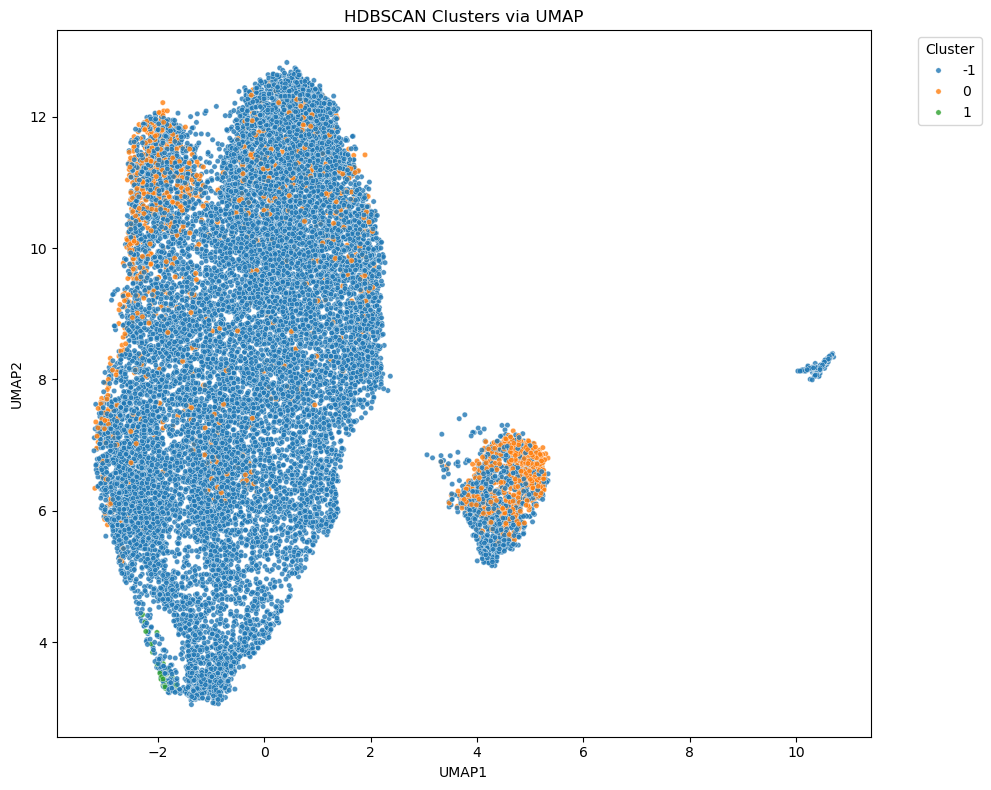

In [6]:
import umap.umap_ as umap
from sklearn.manifold import TSNE


#dimensionality reduction for visualization
print(np.unique(labels))


reducer = umap.UMAP(metric='precomputed') #must match metric for HDBSCAN
embedding = reducer.fit_transform(gower_matrix)

# Assuming you have a UMAP 2D embedding and cluster labels
embedding_df = pd.DataFrame({
    'UMAP1': embedding[:, 0],
    'UMAP2': embedding[:, 1],
    'cluster': labels  # array of cluster labels including -1 for noise
})

# Convert cluster column to categorical so seaborn doesn't treat it as continuous
embedding_df['cluster'] = embedding_df['cluster'].astype(str)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=embedding_df,
    x='UMAP1', y='UMAP2',
    hue='cluster',
    palette='tab10',  # or use sns.color_palette('hls', n_colors)
    s=15,
    alpha=0.8
)
plt.title('HDBSCAN Clusters via UMAP')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# #visualize via TSNE
# tsne = TSNE(metric="precomputed", init='random', random_state=42)
# embedding_tsne = tsne.fit_transform(gower_matrix)

# plt.scatter(embedding_tsne[:,0], embedding_tsne[:, 1], c=labels, cmap='Spectral')
# plt.title("t-SNE of Clusters")

In [7]:
from sklearn.ensemble import RandomForestClassifier

#determine feature importance

importances = RandomForestClassifier().fit(df_imputed, labels).feature_importances_
importance_df = pd.DataFrame({
    'feature' : df_imputed.columns,
    'importance' : importances
}).sort_values(by='importance', ascending=False)

print(importance_df.head())



          feature  importance
166  InjuryPeriod    0.031863
120  FIMLocoModeD    0.031787
27        FIMMOTD    0.023085
28        FIMTOTA    0.022593
29        FIMTOTD    0.017737


C:\Users\benol\AppData\Local\Temp\ipykernel_12264\2432658822.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


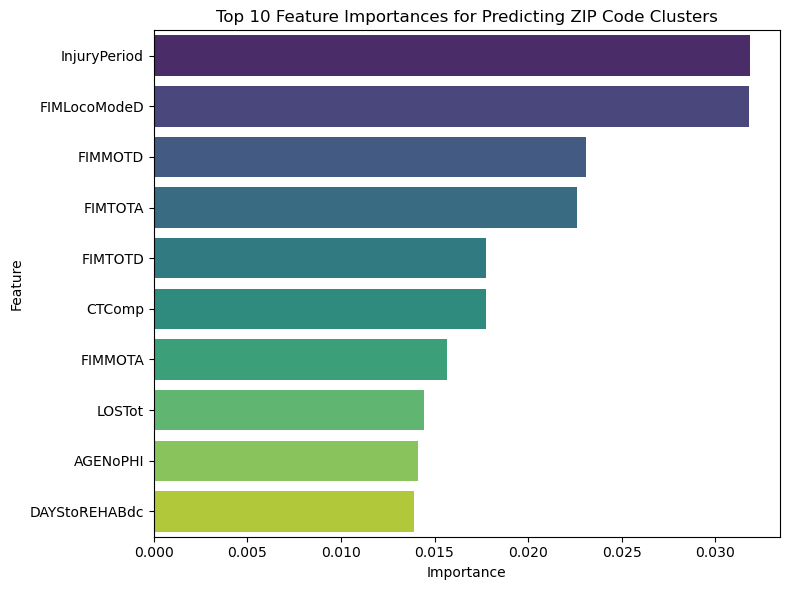

In [8]:
import seaborn as sns

top_features = importance_df.head(10)

plt.figure(figsize=(8, 6))
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 10 Feature Importances for Predicting ZIP Code Clusters')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [9]:

import pgeocode
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import plotly.graph_objects as go

nomi = pgeocode.Nominatim('us')

#create zipcodes count
zipcodes_count = df['ZipInj'].value_counts().reset_index()
zipcodes_count.columns = ['zipcode', 'count']
zipcodes_count['zipcode'] = zipcodes_count['zipcode'].astype(int).astype(str).str.zfill(5) #to zero pad zipcodes

geo_info = nomi.query_postal_code(zipcodes_count['zipcode'].tolist())

geo_info.head()

zipcodes_count['Latitude'] = geo_info['latitude'].values
zipcodes_count['Longitude'] = geo_info['longitude'].values

fig = go.Figure(data=go.Scattergeo(
        lon = zipcodes_count['Longitude'],
        lat = zipcodes_count['Latitude'],
        text = zipcodes_count['zipcode'] + ": " + zipcodes_count['count'].astype(str),
        mode = 'markers',
        marker = dict(
            size = 3,
            color = zipcodes_count['count'],
            colorscale = 'Viridis',
            colorbar_title = "Count",
            opacity = 0.9
        )
))

fig.update_layout(
        title = 'ZIP Code Distribution of Injuries',
        geo_scope='usa',
        width = 1000,    # width in pixels
        height = 700     # height in pixels
        )

fig.show()

In [12]:

zipcodes_labeled = df_with_clusters['cluster'].reset_index()
zipcodes_labeled.columns = ['zipcode', 'cluster']
zipcodes_labeled['zipcode'] = zip_codes

#zipcodes_labeled = zipcodes_labeled.groupby('zipcode')['cluster'].median().reset_index()
zipcodes_labeled['zipcode'] = zipcodes_count['zipcode'].astype(int).astype(str).str.zfill(5)

zipcodes_labeled = zipcodes_labeled[zipcodes_labeled['cluster'] != -1]

geo = nomi.query_postal_code(zipcodes_labeled['zipcode'].tolist())

zipcodes_labeled['latitude'] = geo['latitude'].values
zipcodes_labeled['longitude'] = geo['longitude'].values


fig = go.Figure(data=go.Scattergeo(
        lon = zipcodes_labeled['longitude'],
        lat = zipcodes_labeled['latitude'],
        text = zipcodes_labeled['zipcode'] + ": " + zipcodes_labeled['cluster'].astype(str),
        mode = 'markers',
        marker = dict(
            size = 6,
            color = zipcodes_labeled['cluster'],
            colorscale = 'Viridis',
            colorbar_title = "Count",
            opacity = 1
        )
))

fig.update_layout(
        title = 'ZIP Code Distribution of Clusters',
        geo_scope='usa',
        width = 1000,    # width in pixels
        height = 700     # height in pixels
        )

fig.show()

In [ ]:
zipcodes_labeled['cluster'].value_counts()


cluster
0    1843
1      41
Name: count, dtype: int64

In [ ]:
df_with_clusters['cluster'].value_counts()

cluster
-1    17676
 0     1843
 1       41
Name: count, dtype: int64